Importing Pandas and Numpy

In [1]:
import pandas as pd
import numpy as np

Printing 'Hello Capstone Project Course!'

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


Importing package for getting and parsing HTML file

In [3]:
from bs4 import BeautifulSoup
import requests
import lxml

Getting HTML file, source of a web-page

In [4]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

Making a 'soup', loading HTML file into BeautifulSoup parser

In [5]:
soup = BeautifulSoup(response.text, 'html.parser')

Finding necessary table in HTML file

In [6]:
table = soup.find('table')

Converting table into a Pandas DataFrame

In [7]:
df = pd.read_html(str(table))[0]

Lets watch at first and last 5 rows, using .tail() and .head() methods

In [8]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [9]:
df.tail()

,Postal Code,Borough,Neighborhood
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."
179,M9Z,Not assigned,NaN


As we can see, there are lots of 'Not assigned' ana 'Nan' cells. Lets deal with it

In [10]:
df.drop(df.loc[df.Borough == 'Not assigned', :].index, axis=0, inplace=True)

Lets watch at DataFrame again

In [11]:
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Reindexing rows

In [12]:
df.index = [i for i in range(len(df))]

Lets get shape of the DataFrame

In [13]:
df.shape

(103, 3)

Loading geodata into coords DataFrame

In [14]:
coords = pd.read_csv('Geospatial_Coordinates.csv')

Lets take a look at the data

In [15]:
coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Checking its shape

In [16]:
coords.shape

(103, 3)

Data in file is unsorted. So lets sort it and create a sorted dataframe with coords at same places as in main DataFrame df. Also lets see the shape

In [49]:
sorted_list = pd.DataFrame()
for num1, i in enumerate(df.loc[:, 'Postal Code']):
    for num2, j in enumerate(coords.loc[:, 'Postal Code']):
        if j == i:
            sorted_list = pd.concat([sorted_list, coords.loc[num2, ['Latitude', 'Longitude']] ], axis=1, ignore_index=True)
sorted_list = sorted_list.T
sorted_list.shape

(103, 2)

Lets contacenate it to our main DataFrame

In [51]:
df = pd.concat([df, sorted_list], axis=1)

Lets take a look at the data

In [52]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7533,-79.3297
1,M4A,North York,Victoria Village,43.7259,-79.3156
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895


Importing libraries

In [54]:
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim

Getting coords af Toronto via geopy

In [55]:
address = 'Toronto'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Creating map of Toronto

In [71]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

Printing neighborhood markers on map

In [72]:
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

Let's take a look on map

In [73]:
map_toronto

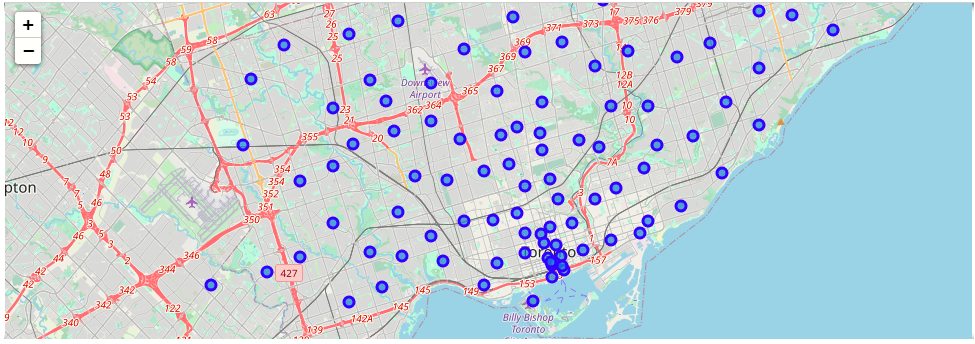

creating variables for using foursquare api

In [140]:
CLIENT_ID = 'GGOLUZUYY5SAJDVDC2L2HRYDNZM2BWZJMW4BTNFG3UE2Y1EK'
CLIENT_SECRET = 'ZYI4YK1WOLODKQOUIIBWA1EXHN5O2KUKWWEWJOH1CYA0PQDU'
VERSION = '20200515' # Foursquare API version
LIMIT = 100
radius= 500

creating function to explore nearby venues

In [147]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using function

In [148]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'],longitudes=df['Longitude'], radius=radius)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

Let's get shape of a frame and print first 5 rows

In [150]:
print(toronto_venues.shape)
toronto_venues.head()

(2108, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Grpuping venues by neighborhood and counting how many venues in each neighborhood

In [151]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Wexford, Maryvale",4,4,4,4,4,4
Willowdale,38,38,38,38,38,38
Woburn,3,3,3,3,3,3


In [193]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

pd.set_option('display.max_columns', None)

In [194]:
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

grouping by neighborhood

In [156]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0

showing frequency top 5 venues for each neighborhood

In [157]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0               Skating Rink   0.2
1                     Lounge   0.2
2             Breakfast Spot   0.2
3  Latin American Restaurant   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
         venue  freq
0  Pizza Place  0.22
1  Coffee Shop  0.11
2          Pub  0.11
3     Pharmacy  0.11
4          Gym  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0              Bank  0.10
1       Coffee Shop  0.10
2        Restaurant  0.05
3  Sushi Restaurant  0.05
4       Supermarket  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3                 Café  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0       Italian Restaurant  0.09
1              Coffee Shop  0.09
2           Sandwich Place  0.09
3  Comfort Food Restaur

                    venue  freq
0  Furniture / Home Store   0.5
1          Baseball Field   0.5
2             Yoga Studio   0.0
3      Miscellaneous Shop   0.0
4     Monument / Landmark   0.0


----Humewood-Cedarvale----
                       venue  freq
0                      Field  0.33
1                      Trail  0.33
2               Hockey Arena  0.33
3  Middle Eastern Restaurant  0.00
4        Monument / Landmark  0.00


----India Bazaar, The Beaches West----
                  venue  freq
0  Fast Food Restaurant  0.10
1           Pizza Place  0.10
2        Sandwich Place  0.10
3     Fish & Chips Shop  0.05
4                   Pub  0.05


----Kennedy Park, Ionview, East Birchmount Park----
                venue  freq
0   Convenience Store  0.17
1         Bus Station  0.17
2    Department Store  0.17
3  Chinese Restaurant  0.17
4         Coffee Shop  0.17


----Kensington Market, Chinatown, Grange Park----
                   venue  freq
0                   Café  0.09
1           

4                 Bank  0.06


----The Annex, North Midtown, Yorkville----
            venue  freq
0            Café  0.13
1  Sandwich Place  0.13
2     Coffee Shop  0.09
3        Pharmacy  0.04
4             Pub  0.04


----The Beaches----
               venue  freq
0                Pub   0.2
1  Health Food Store   0.2
2   Asian Restaurant   0.2
3              Trail   0.2
4        Yoga Studio   0.0


----The Danforth West, Riverdale----
                    venue  freq
0        Greek Restaurant  0.21
1      Italian Restaurant  0.07
2             Coffee Shop  0.07
3  Furniture / Home Store  0.05
4              Restaurant  0.05


----The Kingsway, Montgomery Road, Old Mill North----
                       venue  freq
0                      River   0.5
1                       Pool   0.5
2                Yoga Studio   0.0
3  Middle Eastern Restaurant   0.0
4        Monument / Landmark   0.0


----Thorncliffe Park----
               venue  freq
0     Sandwich Place  0.11
1  Indian Restauran

function for returning most common venues for neighborhoods

In [158]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

returning 10 most common venues for neighborhoods

In [159]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Clothing Store,Breakfast Spot,Latin American Restaurant,Ethiopian Restaurant,Electronics Store,Event Space,Dim Sum Restaurant,Eastern European Restaurant
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pool,Gym,Skating Rink,Pharmacy,Pub,Sandwich Place,Deli / Bodega,Department Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Supermarket,Pharmacy,Shopping Mall,Fried Chicken Joint,Frozen Yogurt Shop,Diner,Pizza Place,Gas Station
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dessert Shop
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Pub,Café,Butcher,Restaurant


creating 10 clusters 

In [188]:
kclusters = 10
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_

array([4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1, 0, 4, 1, 4, 1,
       4, 4, 4, 4, 7, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5, 4, 1, 4, 4,
       1, 4, 3, 4, 4, 2, 8, 4, 4, 1, 3, 4, 6, 4, 5, 4, 1, 3, 4, 4, 4, 8,
       9, 3, 4, 1, 8, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 9, 1,
       8, 4, 4, 7, 4, 3])

creating dataframe

In [189]:
toronto_merged = df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
pd.set_option('display.max_rows', None)
toronto_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.7533,-79.3297,3.0,Food & Drink Shop,Park,Construction & Landscaping,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
1,M4A,North York,Victoria Village,43.7259,-79.3156,1.0,Portuguese Restaurant,Hockey Arena,Pizza Place,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606,4.0,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Cosmetics Shop,Shoe Store,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648,4.0,Clothing Store,Accessories Store,Boutique,Vietnamese Restaurant,Furniture / Home Store,Event Space,Coffee Shop,Miscellaneous Shop,Dog Run,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895,4.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Sandwich Place,Burrito Place,Café,College Auditorium,Music Venue
5,M9A,Etobicoke,Islington Avenue,43.6679,-79.5322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,M1B,Scarborough,"Malvern, Rouge",43.8067,-79.1944,2.0,Fast Food Restaurant,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
7,M3B,North York,Don Mills,43.7459,-79.3522,4.0,Asian Restaurant,Gym,Restaurant,Japanese Restaurant,Coffee Shop,Beer Store,Concert Hall,Dim Sum Restaurant,Café,Discount Store
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7064,-79.3099,1.0,Pizza Place,Pet Store,Gastropub,Pharmacy,Café,Breakfast Spot,Intersection,Bank,Athletics & Sports,Fast Food Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789,4.0,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Japanese Restaurant,Café,Restaurant,Cosmetics Shop,Bubble Tea Shop,Italian Restaurant,Diner


dropping NaN values and converting dtype of Cluster Labels

In [190]:
toronto_merged.dropna(axis=0, inplace=True)
toronto_merged.index = [i for i in range(len(toronto_merged))]
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.7533,-79.3297,3,Food & Drink Shop,Park,Construction & Landscaping,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
1,M4A,North York,Victoria Village,43.7259,-79.3156,1,Portuguese Restaurant,Hockey Arena,Pizza Place,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606,4,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Cosmetics Shop,Shoe Store,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648,4,Clothing Store,Accessories Store,Boutique,Vietnamese Restaurant,Furniture / Home Store,Event Space,Coffee Shop,Miscellaneous Shop,Dog Run,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895,4,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Sandwich Place,Burrito Place,Café,College Auditorium,Music Venue
5,M1B,Scarborough,"Malvern, Rouge",43.8067,-79.1944,2,Fast Food Restaurant,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
6,M3B,North York,Don Mills,43.7459,-79.3522,4,Asian Restaurant,Gym,Restaurant,Japanese Restaurant,Coffee Shop,Beer Store,Concert Hall,Dim Sum Restaurant,Café,Discount Store
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7064,-79.3099,1,Pizza Place,Pet Store,Gastropub,Pharmacy,Café,Breakfast Spot,Intersection,Bank,Athletics & Sports,Fast Food Restaurant
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789,4,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Japanese Restaurant,Café,Restaurant,Cosmetics Shop,Bubble Tea Shop,Italian Restaurant,Diner
9,M6B,North York,Glencairn,43.7096,-79.4451,4,Park,Asian Restaurant,Pub,Japanese Restaurant,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


importing libraries for making color markers on folium map

In [191]:
import matplotlib.cm as cm
import matplotlib.colors as colors

creating folium map with clusters

In [196]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


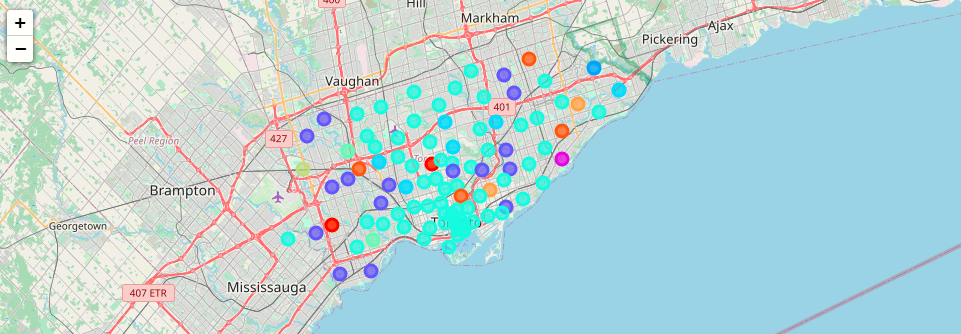